# 댓글 군집화
* 올라와 있는 댓글들을 대표적인 의견으로 묶고 어떠한 의견이 있는지 살펴보기 위함
* 감정분석 모델도 계속 찾기
---
1. 데이터 다운 -> 네이버 데이터랩
2. 데이터 전처리 벡터로 변환
3. k-means
4. 시각화

### 데이터 다운
1.기사
2. 댓글

In [38]:
%config Completer.use_jedi = False


import sys
sys.getdefaultencoding()
import os

import re
import requests
from pathlib import Path
from datetime import datetime
import pandas as pd
import collections as co

client_id = "OP08QraFd_zLrAfjBrTA"  
client_secret = "qcS0nZixH7"

In [17]:
start_date = datetime(2021,11, 3)
end_date = datetime(2021,11, 8)
str_date = end_date.strftime("%Y-%m-%d")

In [13]:
keyword = "김동연"
respond_type = "json"
Ndisplay = 100
sort_type = 'sim'

headers = {
    'X-Naver-Client-Id' : client_id, 
    'X-Naver-Client-Secret':client_secret

}


res = pd.DataFrame({ 'title': [None], 'originallink': [None], 'link': [None], 'description': [None], 'pubDate': [None] }) 

for start in range(1,1001, 100):
    search_word = re.sub('[^0-9a-zA-Zㄱ-힗]', ' ', keyword) 
    url = f"https://openapi.naver.com/v1/search/news.{respond_type}?query={keyword}&display={str(int(Ndisplay))}&start={str(int(start))}&sort={sort_type}"
    r = requests.get(url, headers=headers) 
    print(r.status_code)
    if r.status_code == 200: 

        temp = pd.DataFrame(r.json()['items']) 

    else: 
        print('error with errorCode:' + r.status_code)

    res = res.append(temp)

200
200
200
200
200
200
200
200
200
200


In [21]:
res = res.dropna()

res['pubDate'] = pd.to_datetime(res['pubDate'])
res['pubDate'].loc[0].tolist()[0].strftime("%Y-%m-%d")

res['pubDate'] =  res['pubDate'].map(lambda x : x.strftime("%Y-%m-%d"))
res['pubDate'] = pd.to_datetime(res['pubDate'])

res = res[(res['pubDate'] > start_date) & (res['pubDate'] < end_date)]

Path("../sns_data/{}/article".format(str_date)).mkdir(parents=True, exist_ok=True)
res.to_csv("../sns_data/{}/article/article.csv".format(str_date), encoding='utf-8')

In [41]:
from selenium import webdriver 
from selenium import webdriver as wd
 
from selenium.webdriver.chrome.options import Options

from datetime import datetime
import pandas as pd
import numpy as np
import os
import collections as co

import time

url = 'https://news.naver.com/main/read.naver?mode=LSD&mid=shm&sid1=102&oid=079&aid=0003561032'

driverPath = "/usr/bin/chromedriver"

chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome(driverPath,chrome_options=chrome_options)
driver.implicitly_wait(30)
driver.get(url)

#Back-up 
def backup(i, article, reples, str_date="temp"): 
    fpath = '../sns_data//{}/reple/'.format(str_date)
    
    if not os.path.exists(fpath) :
        Path(fpath).mkdir(parents=True, exist_ok=True)
    
    if reples:
        if (int(i)-1) % 10 == 0: 
            # free article body 
            res_article = pd.DataFrame(article) 
            fname = fpath + 'NaverNews_Exist_article'+str(i)+'.csv'.format(str_date)
            res_article.to_csv(fname, index=False, encoding='utf-8-sig') 
            del res_article, article 
            log.write(message+'Delete res, article and free memory') 
            log.write(message+'Re-create article') 
            article = co.deque([]) 
            # free article reple 
            res_reple = pd.concat(reples) 
            fname = fpath + 'reple'+str(i)+'.csv'
            res_reple.to_csv(fname, index=False, encoding='utf-8-sig') 
            del res_reple, reples 
            log.write(message+'Delete res, article and free memory') 
            log.write(message+'Re-create article') 
            reples = co.deque([])
            
def enter_URL(url): 

    #import ipdb; ipdb.set_trace(context=15)
    try: 
#             driver = wd.Chrome(executable_path=driverPath) 
#             driver.get(url) 

        chrome_options = Options()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        driver = webdriver.Chrome(driverPath,chrome_options=chrome_options)
        driver.implicitly_wait(30)
        driver.get(url)
        return True
        
        
    except:
        print("error")
        log.write(message+'error with get URL... maybe Blocked IP... sleep 10 sec...') 
        log.write(message+'restart') 

        return False

# Get data - Article body 
def Get_Article_Body(i, article, url): 
    
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(driverPath,chrome_options=chrome_options)
    driver.implicitly_wait(30)
    driver.get(url)
    body = driver.find_elements_by_xpath("//div[@id='articleBodyContents']") 
    print("temp")
    text = "" 
    for b in body: 
        text = text.join(b.text) 
    
    # re-enter 
    if text.strip(url) == '': 
        log.write(message+'there`s no article... maybe loading error') 
        driver.refresh() 
        log.write(message+'refresh...') 
        log.write(message+'sleep 5 sec...') 
        time.sleep(5) 
        log.write(message+'try again...') 
        driver.get(url) 
        body = driver.find_elements_by_xpath("//div[@id='articleBody']") 
        text = "" 
        for b in body: 
            text = text.join(b.text) 
            
        tmp_article = { 'NaverURL':url, 'body':text } 
        article.append(tmp_article)
    
    return article

# Get data - Article reple 
def Get_Ariticle_reple(i, reples, record): 
    
        
    title = record[1]['title']
    pubDate = record[1]['pubDate']
    description = record[1]['description']
    
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(driverPath,chrome_options=chrome_options)
    driver.implicitly_wait(30)
    driver.get(url)
    log.write(message+'sleep 2 sec for scrap reples...') 
    time.sleep(2) 
    noReple = False 
    #no_reple = pd.DataFrame({ 'repleID':[None], 'reple':[None], 'time':[None], 're_reple':[None], 'like':[None], 'dislike':[None], 'NaverURL':[None] }) 
    no_reple = pd.DataFrame({}) 
    try: # Click more reple 
        driver.find_elements_by_xpath("//span[@class='u_cbox_in_view_comment']")[0].click() 
    except: 
        print("No Reple")
        noReple = True 
    
    if noReple: 
        tmp_reple = no_reple 
    else: 
        log.write(message+'there are some reples... refresh and sleep 2 sec to scrap all data...') 
        driver.refresh() 
        time.sleep(2) # 총 댓글 갯수 확인 
    
    if noReple:
        pass
    else :    
        Nreple = driver.find_element_by_xpath("//span[@class='u_cbox_count']") 
        Nreple = Nreple.text 
        Nreple = int(Nreple.replace(',','')) 
        print(Nreple) 
        if Nreple > 20: 
            NrepleLoop = (Nreple//20) if Nreple%20 > 0 else (Nreple//20)-1 
            for i in range(NrepleLoop): 
                driver.find_elements_by_xpath("//span[@class='u_cbox_page_more']")[0].click() 
                time.sleep(1) 

    # 댓글 수집 
    contents = []
    try :
        contents = driver.find_elements_by_css_selector('span.u_cbox_contents')
    
    except :
        print("Error")
    
    tmp_reple = pd.DataFrame({})
    if len(contents) > 0:
        tmp_reple = co.deque([])
        for content in contents:
            print("content", content.text)
            tmp_list = content.text.split("\n")
            tmp_reple.append(tmp_list)
        tmp_reple = pd.DataFrame(tmp_reple)
        tmp_reple['NaverURL'] = url
        tmp_reple['pubDate'] = pubDate
        tmp_reple['description'] = description
                


#     reple = driver.find_elements_by_xpath('//div[@class="u_cbox_comment_box"]') 
    
#     if len(reple) > 0:
#         # 댓글이 적어도 하나라도 있는 경우: 클린봇 X, 삭제 X 
#         tmp_reple = co.deque([]) 
#         for r in reple: 
#             tmp_list = r.text.split('\n') 
#             if len(tmp_list) == 11: 
#                 tmp_reple.append(tmp_list) 
#         tmp_reple = pd.DataFrame(tmp_reple) 
#         if len(tmp_reple) == 0: 
#             # 댓글 하나만 있는데 삭제되었을 때 
#             tmp_reple = no_reple 
#         else: 
            
#             tmp_reple = tmp_reple[[0,3,4,5,8,10]].rename(columns={ 0:'repleID', 3:'reple', 4:'time', 5:'re_reple', 8:'like', 10:'dislike' }) 
#             tmp_reple['NaverURL'] = url 
            
#     else: 
#         tmp_reple = no_reple 
    reples.append(tmp_reple)
    return reples

/home/nakyil/anaconda3/envs/DLassn/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: use options instead of chrome_options


In [ ]:
start = 0
res['index'] = list(range(res.shape[0]))

URLs = res
article = []
reples = []
reples_total = []

log_file = "../sns_data/{}/article/log_".format(str_date)  + datetime.strftime(datetime.now(), "%Y%m%d_%H%M%S") + '.txt'

log = open(log_file, 'w') 
log.write('start program: '+datetime.strftime(datetime.now(), "%H:%M:%S.%f")) 
print('start program: '+datetime.strftime(datetime.now(), "%H:%M:%S.%f"))

for idx, record in enumerate(URLs.iloc[start:].iterrows()):
    print("======================")
    print("Start ", idx+ start)
    i = record[1]['index']
    url = record[1]['link']

    if url == None:
        continue
    message = '\n'+datetime.strftime(datetime.now(), "%H:%M")+' '+str(i)+'th loop | '
# Back-up function # Article body function # Article reple function
    print("Back up")
    backup(i, article, reples, str_date=str_date)
    print("Enter URL")
    accessed = enter_URL(url)
    
    if accessed :
        print("Get Article Body")
        article = Get_Article_Body(i, article, url)
        print("Get reple")
        reples = Get_Ariticle_reple(i, reples, record)
        reples_total.extend(reples)

        driver.quit() 
        message2 = '\n'+datetime.strftime(datetime.now(), "%H:%M")+' '+str(i)+'th loop | ' 
        log.write(message2+'NaverURL: '+url) 
        print(message2+'NaverURL: '+url)
    
res_article = pd.DataFrame(article)
res_reple = pd.concat(reples)
res_article.to_csv('../sns_data/{}/article/NaverNews_article.csv', index=False)
res_reple.to_csv('../sns_data/{}/article/NaverNews_reple.csv', index=False)

log.write('\n end program: '+datetime.strftime(datetime.now(b), "%H:%M:%S.%f"))
print('end program')

log.close()



start program: 10:00:24.440590
Start  0
Back up
Enter URL


/home/nakyil/anaconda3/envs/DLassn/lib/python3.6/site-packages/ipykernel_launcher.py:63: DeprecationWarning: use options instead of chrome_options


Get Article Body


/home/nakyil/anaconda3/envs/DLassn/lib/python3.6/site-packages/ipykernel_launcher.py:83: DeprecationWarning: use options instead of chrome_options


temp
Get reple


/home/nakyil/anaconda3/envs/DLassn/lib/python3.6/site-packages/ipykernel_launcher.py:123: DeprecationWarning: use options instead of chrome_options


356
content 진짜 사악한놈입니다. 벼락출세는 누가시켰냐? 문재인이 시키고 쩝쩝거리면서 살아있는 권력 수사하라고 하더니 막상 수사하니까 그다음부터는 째려보고 탄압했잖아요. 왜 윤석열 방해하라고 문재인 지시가 내려왔나요? 이재명은 잘했다고 생각하는지 묻고 싶습니다.
content 동연이도 뭉가정부의 벼락출세인중 한명 아닌가?
content ㅋ 김동연 민주당 2중대네 송영길이 참석하고 하더니 윤총한테 총질하는 인간들이 어찌 이렇게 많나
content 동연아 니코가 석자다..남의 콧물보고 흉볼때가 아니다
content 김동연 왜자꾸 때리지? 별꼴이야 그러면 지지율 오르나요?
content 문재인의 제일 큰 패착ㅡ정치검사 윤석열을 검사 서열을 깡그리 무시하고 검찰총장 시킨것ㅡ지금 이 사단은 문재인의 자업자득이다
content 우리는 지금 진행중인 개검쿠테타의 현실을 보고 있습니다... 전관비리 없애고자, 검찰을 개혁하겠다 하니, 아예, 개검들이 정권을 잡겠다고, 국짐과 야합하고 있지요... 춘장이 대권을 잡으면, 국짐은 결국 개검들한테 먹히고 말 것이고... 나라는 결단 나는거지요... 검찰 기소율 0.1%, 전관 변호사가 된 후 수백억 수임. 그때 파생되는 유전무죄 문제들... 정권교체 좋아하는 분들 어떤 세상이 좋은지 생각해보길 바랍니다...
content 김동연씨 속알머리 밴댕이네...주변에 실력있는 인재 등용해서 쓰는 게 대통령 역할입니다.대통령이 모든 걸 다 알 수는 없어요.
content 윤석렬의 살아온 과정을 보면 기득권 타파는 어림없는 예기고 오히려 그들을 보호하기위해 서민들만 법대로라는 미명하에 족쳐대는 본성을 가지고 있는 사람이라 중상류층이하는 그에대한 희망을 버리시길 바랍니다
content 옳소 ! 검사권력 권한으로 자신의 범죄와 처.장모 범죄수십건을 뭉게고 덮은데 악용하면서 공정.상식.법치 ? 말하는 윤석열 입에 똥을쑤셔넣어한다 . 거기다가 검언유착 에 뒤지게생겼으니 한동훈 보호하려고 노골적 감찰방해.수사방해.판사사찰까지 하여 면직이상의 

In [46]:
res_article = pd.DataFrame(article)
res_reple = pd.concat(reples)
res_article.to_csv('../sns_data/{}/article/NaverNews_article.csv'.format(str_date)
                   , index=False)
res_reple.to_csv('../sns_data/{}/article/NaverNews_reple.csv'.format(str_date)
                 , index=False)


## 댓글 전처리

In [267]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
from tqdm import tqdm

In [268]:
train_data = res_reple[[0, 'pubDate', 'description']]
train_data.columns = ['document', 'pubDate', 'description']

In [269]:
train_data = train_data.dropna(how='any')
print(train_data.isnull().values.any())

False


In [294]:
stopwords = ['을', '다', '이다', '있다', '없다', '다', '로', '것', '에서','만','말',
             '적', '거', '아', '하고', '가다', '그', '나', '명',
             '당','로','보다','의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


In [295]:
# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

p = re.compile("[.,!?\"':;~()]")

tokenized_data = []
for sentence in tqdm(train_data['document']):
    sentence = re.sub(p, "", sentence)
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거

    tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 7146/7146 [00:13<00:00, 518.61it/s]


In [296]:
sentence

'먼 소리야 홍 떨어지고 젊은층 다 빠져나갔는데 늙은이들 착각빠지게 하는 기사'

리뷰의 최대 길이 : 138
리뷰의 평균 길이 : 14.781556115309264


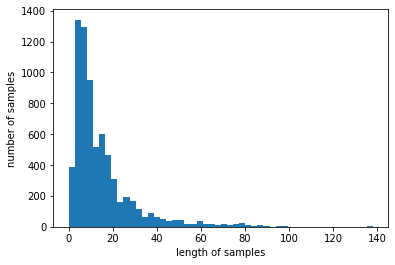

In [297]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [298]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [299]:
model.wv.index2word

['되다',
 '윤석열',
 '이재명',
 '국민',
 '정권',
 '아니다',
 '대통령',
 '후보',
 '사람',
 '김동연',
 '안철수',
 '교체',
 '나오다',
 '민주당',
 '같다',
 '나라',
 '고',
 '못',
 '안',
 '대선',
 '지지',
 '들다',
 '않다',
 '지',
 'ㅋㅋ',
 '여론조사',
 '그렇다',
 '정치',
 '좋다',
 '게',
 '네',
 '대다',
 '생각',
 '더',
 '인',
 '홍준표',
 '니',
 '대',
 '표절',
 '뭐',
 '안되다',
 'ㅋㅋㅋ',
 '하',
 '대한민국',
 '라',
 '문',
 '인간',
 '윤',
 '내',
 '놈',
 '수',
 '문재인',
 '때',
 '죄명',
 '찍다',
 '까지',
 '에게',
 '받다',
 '알다',
 '개',
 '이제',
 '왜',
 '저',
 '2030',
 '대장동',
 '이나',
 '모르다',
 '인데',
 '힘',
 '찢다',
 '지다',
 '냐',
 '야',
 'ㅋ',
 '많다',
 'ㅋㅋㅋㅋ',
 '이번',
 '님',
 '이렇다',
 '진짜',
 '요',
 '제',
 '만들다',
 '믿다',
 '뽑다',
 '지금',
 '너',
 '국힘',
 '지지율',
 '조사',
 '맞다',
 '면',
 '표',
 '기득권',
 'ㅡ',
 '먹다',
 '나다',
 '4',
 '정책',
 '또',
 '보수',
 '시키다',
 '윤석렬',
 '재',
 '되어다',
 '일',
 '누가',
 '전',
 '민심',
 '한테',
 '그냥',
 '석',
 '서',
 '걸',
 '정부',
 '내다',
 '오다',
 '뉴데일리',
 '자다',
 '차다',
 '쓰다',
 '프로',
 '선거',
 '부터',
 '30%',
 '범',
 '무슨',
 '결과',
 '상식',
 '이고',
 '심상정',
 '당신',
 '열',
 '기',
 '넘다',
 '조작',
 '이지',
 '화이팅',
 '돼다',
 '전과',
 '2',
 '어떻다',
 '언론',
 '기회',
 

In [300]:
# Get word vectors
model.wv.word_vec('김동연')

array([ 0.29511842,  0.5046029 , -0.10473702, -0.51233804, -0.29665244,
        0.2147737 ,  0.07926577, -0.5578572 , -0.01923348, -0.28536507,
        0.00653172,  0.71748096,  0.12133028,  0.3705049 , -0.40351337,
        0.14743012,  0.34082106, -0.2116375 , -0.53067505, -0.60085845,
        0.05525241,  0.15445322,  0.05523274, -0.06121051,  0.04394791,
       -0.4274022 , -0.07400218,  0.11517057, -0.5476948 ,  0.932054  ,
        0.32322437,  0.00332947,  0.3058306 , -0.00162331, -0.02917842,
       -0.2162803 ,  0.0372412 ,  0.36127138, -0.2699494 ,  0.02104785,
        0.07487644,  0.3210857 , -0.21731769,  0.5413021 ,  0.19917119,
       -0.38770455,  0.40003458, -0.06609584,  0.36011016, -0.24399996,
       -0.22760442, -0.33911446, -0.21785557,  0.46678677,  0.29559523,
       -0.19425881, -0.02270849,  0.34356204,  0.16724455,  0.07910608,
       -0.23972207, -0.82284445, -0.48671916,  0.5303577 , -0.36023322,
       -0.20800914,  0.5812153 , -0.31223297,  0.2226404 , -0.16

In [199]:
vocab_keys = model.wv.vocab.keys()

In [217]:

sentence_vectors = np.empty((0,100))
for words in tokenized_data:
    cnt = 0
    vec = np.empty((1,100))

    for word in words:
        if word in vocab_keys:
            vec += model.wv.word_vec(word)
            cnt += 1    
        if cnt != 0 :
            vec /= cnt
    
    sentence_vectors = np.vstack((sentence_vectors, vec.reshape(1,100)))    

## 시각화

In [301]:
from sklearn.manifold import TSNE
import seaborn as sns

### 단어 시각화

In [331]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore")


In [340]:
from matplotlib import font_manager

font_dirs = ['./NanumBarunGothic.ttf']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'NanumBarunGothic'

In [327]:
words = model.wv.index2word

In [328]:
word_vectors = model.wv.vectors

In [349]:
n_components = 2
tsne_model = TSNE(n_components=n_components, perplexity=8)
transformed_vec = tsne_model.fit_transform(word_vectors)

n_words = 10
df = pd.DataFrame(transformed_vec[:n_words])
df['words'] = words[:n_words]

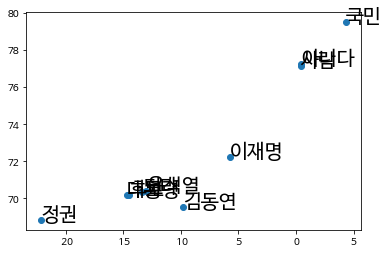

In [354]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df[0], df[1])
for idx, record in df.iterrows():
    ax.text(record[0], record[1], record['words'], fontdict={"fontsize":20})



### 문장 시각화

In [242]:
n_components = 2
tsne_model = TSNE(n_components=n_components, perplexity=8)
transformed_vec = tsne_model.fit_transform(sentence_vectors)

In [239]:
transformed_vec.shape

(7146, 2)

In [240]:
train_data['x'] = transformed_vec[:, 0]
train_data['y'] = transformed_vec[:, 1]

In [ ]:
train_data.te

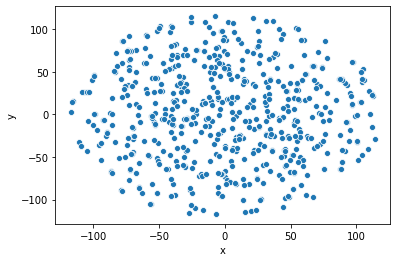

In [254]:
sns.scatterplot(data=train_data.iloc[:600], x='x', y='y', )

In [246]:
model.wv.most_similar("김동연")

[('되어다', 0.9997097849845886),
 ('때', 0.9996748566627502),
 ('출마', 0.9996681213378906),
 ('님', 0.9996660947799683),
 ('응원', 0.9996657371520996),
 ('후', 0.9996598958969116),
 ('싫다', 0.9996585249900818),
 ('씨', 0.9996440410614014),
 ('야당', 0.9996316432952881),
 ('확실하다', 0.9996281266212463)]

In [249]:
model.wv.most_similar('윤석열')

[('.', 0.9990728497505188),
 ('문재인', 0.9988996982574463),
 ('!!', 0.9988851547241211),
 ('이번', 0.9988051652908325),
 ('원하다', 0.9987707734107971),
 ('!!!', 0.9986900091171265),
 ('야권', 0.998599648475647),
 ('대세', 0.9985572695732117),
 ('꼭', 0.9985551238059998),
 ('만이', 0.9985511898994446)]

In [250]:
model.wv.most_similar("이재명")

[('뽑다', 0.9992294311523438),
 ('찍다', 0.9991429448127747),
 ('토론', 0.9990175366401672),
 ('지지', 0.999008297920227),
 ('이나', 0.998993992805481),
 ('선출', 0.998963475227356),
 ('어차피', 0.9989545345306396),
 ('받다', 0.9989120960235596),
 ('지지율', 0.9988884925842285),
 ('제', 0.9988841414451599)]